In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_predict
from sklearn.preprocessing import StandardScaler  
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge,LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor


# I- Préparation de la base (voir R)

In [2]:
# Chargement des données

Gym = pd.read_csv("Donnees_projet.csv")

# Conversion des colonnes en catégories (équivalent à factor en R)
Gym['Gender'] = Gym['Gender'].astype('category')
Gym['Workout_Type'] = Gym['Workout_Type'].astype('category')
Gym['Workout_Frequency'] = Gym['Workout_Frequency (days/week)'].astype('category')
Gym['Experience_Level'] = Gym['Experience_Level'].astype('category')

# Renommage des colonnes pour simplifier l'accès
Gym['Session_Duration'] = Gym['Session_Duration (hours)']
Gym['Water_Intake'] = Gym['Water_Intake (liters)']

Gym["BMI"]=Gym["BMI"].map(lambda x: np.sqrt(x))

# Sélection des colonnes d'intérêt
Gym = Gym.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 13, 14, 15, 16, 17]]

# Affichage des premières lignes et résumé statistique
print(Gym.head())
print(Gym.describe(include='all'))

GymDum=pd.get_dummies(Gym[["Gender","Workout_Type","Experience_Level","Workout_Frequency"]])
GymDum = GymDum.drop(columns=["Workout_Type_Cardio","Experience_Level_1","Workout_Frequency_2"])
GymQuant= Gym.select_dtypes(include=['int64', 'float64'])

   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Calories_Burned Workout_Type  Fat_Percentage Experience_Level       BMI  \
0           1313.0         Yoga            12.6                3  5.495453   
1            883.0         HIIT            33.9                2  5.656854   
2            677.0       Cardio            33.4                2  4.970915   
3            532.0     Strength            28.8                1  4.290688   
4            556.0     Strength            29.2                1  3.793415   

  Workout_Frequency  Session_Duration  Water_Intake  
0                 4             

# II- Prévision des calories brûlées

Dans cette partie, nous avons pour objectif de prédire la quantitée de calories brûlées par rapport aux autres variables explicatives à notre disposition. Pour cela, nous allons tester plusieurs modèles et comparer leur efficacité. Pour la suite les variables explicatives qualitatives seront séparées en plusieurs variables par modalitées (par exemple Gender_female/ Gender_Male).

In [3]:
dfC=pd.concat([GymDum,GymQuant],axis=1)
dfC=dfC.drop(columns=["Calories_Burned"])
dfC.head()

,Gender_Female,Gender_Male,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Experience_Level_2,Experience_Level_3,Workout_Frequency_3,Workout_Frequency_4,Workout_Frequency_5,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Fat_Percentage,BMI,Session_Duration,Water_Intake
0,False,True,False,False,True,False,True,False,True,False,56,88.3,1.71,180,157,60,12.6,5.495453,1.69,3.5
1,True,False,True,False,False,True,False,False,True,False,46,74.9,1.53,179,151,66,33.9,5.656854,1.30,2.1
2,True,False,False,False,False,True,False,False,True,False,32,68.1,1.66,167,122,54,33.4,4.970915,1.11,2.3
3,False,True,False,True,False,False,False,True,False,False,25,53.2,1.70,190,164,56,28.8,4.290688,0.59,2.1
4,False,True,False,True,False,False,False,True,False,False,38,46.1,1.79,188,158,68,29.2,3.793415,0.64,2.8


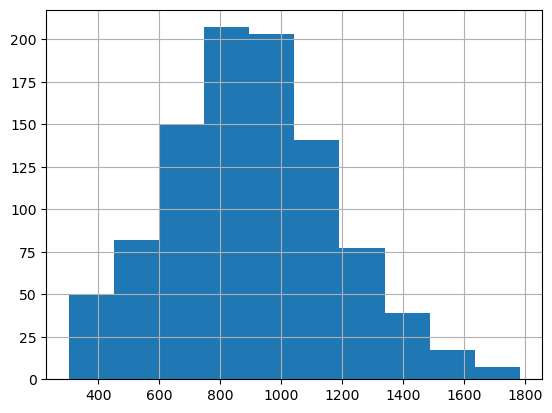

In [4]:
# variable à expliquer réelle
Y=Gym["Calories_Burned"]
Y.hist()
plt.show()

## 1) Séparation de la base en train/test

Avant de pouvoir réaliser nos différents modèle de prédiction, il est d'abord necessaire de séparer nos données en deux parties. La première partie correspond à 80% de la base complète. Elle permet d'entraîner un modèle sur les données qui lui sont fournies. La seconde partie est celle de test. Elle permettra d'appliquer notre modèle entraîné et de comparer les différentes méthodes entre elles.

In [5]:
X_train,X_test,Y_train,Y_test=train_test_split(dfC,Y,test_size=0.2,random_state=11)

In [6]:
# L'algorithme des réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.fit_transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)

## 2)Modèle linéaire 


On s'interesse d'abord aux modèles de type linéaire. Ceux-ci sont vastement utilisés pour leur simplicité et interpretabilité.

### a)Sans Pénalisation

La variable à expliquer étant quantitative, on utilise un modèle de regression linéaire.

In [7]:
# Régression linéaire sans pénalisation
regLin = LinearRegression()

# Entraîner sur tout le train, prédire sur le test
regLin.fit(Xr_train, Y_train)
# Prédiction sur le train
PrevLR_train = regLin.predict(Xr_train)
# Prédiction sur les données de test
PrevLR = regLin.predict(Xr_test)
# Evaluation
r2_test= r2_score(Y_test, PrevLR)
r2_train= r2_score(Y_train, PrevLR_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = Xr_train.shape[1]  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevLR)
mse_train = mean_squared_error(Y_train, PrevLR_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9782
Q² (R²-ajusté sur test) = 0.9791
MSE sur test = 1594.5484
MSE sur train = 1521.0900


Le R2 classique étant fortement élevé, on en déduit que ce modèle à un biais très faible.  Cependant, sans pénalisation, les modèles linéaires ont tendance à faire de l'overfitting pour un nombre de paramètres important. On se retrouve donc avec des modèles trop complexes. Cela se traduit par un R2 ajusté plus faible bien que très satsifaisant. Parla suite, on utilisera principalement la MSE étant une valeure sure pour comparer nos méthodes.

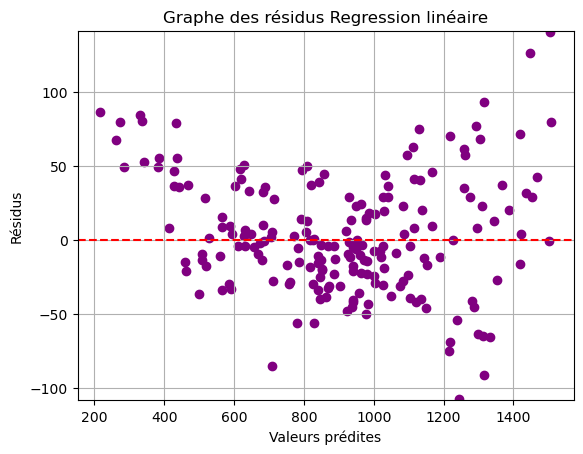

In [8]:
# Calcul des résidus
residusLR = Y_test - PrevLR

# Tracé du graphe des résidus
plt.scatter(PrevLR, residusLR, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Regression linéaire")

plt.ylim(min(residusLR) - 1, max(residusLR) + 1) 
plt.grid(True)
plt.show()

En affichant le graphique des résidus on remarque une forme "en banane" synonyme d'un modèle peu fiable. En effet, si le modèle était bon nous observerions une ligne droit proche de la ligne y=0. Cela confirme que le modèle de régression linéaire sans pénalisation ni sélection de variable n'est pas très efficace pour la prédiction des calories brulées.

### b) Pénalisation

Il est necessaire de trouver un équilibre entre le biais et la variance. En effet dans certaines situation, il est préférable de chosisir un modèle biaisé qui permet de réduire de manière importante la variance que de choisir un modèle à R2 élevé. A cet effet, nous allons utiliser différents critères de pénalisation sur les modèles trop complexes.

#### i.  Sans selection de variable (Ridge)

In [9]:
regRidge = Ridge()

# Grille de valeurs pour alpha (la pénalisation)
alphas = np.linspace(0.01, 10, 100)
param = {'alpha': alphas}
regRidge = GridSearchCV(regRidge, param, cv=5, n_jobs=-1)
regRidgeOpt = regRidge.fit(Xr_train, Y_train)

# paramètre optimal
alpha_opt = regRidgeOpt.best_params_["alpha"]
print("Meilleur paramètre = %s" % (regRidgeOpt.best_params_))

Meilleur paramètre = {'alpha': 0.9181818181818182}


In [10]:
regRidge = Ridge(alpha=alpha_opt)

# Entraîner sur tout le train, prédire sur le test
regRidge.fit(Xr_train,Y_train)
PrevRidge=regRidge.predict(Xr_test)
PrevRidge_train=regRidge.predict(Xr_train)

# Evaluation
r2_test= r2_score(Y_test, PrevRidge)
r2_train= r2_score(Y_train, PrevRidge_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = Xr_train.shape[1]  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevRidge)
mse_train = mean_squared_error(Y_train, PrevRidge_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9782
Q² (R²-ajusté sur test) = 0.9792
MSE sur test = 1589.2928
MSE sur train = 1521.6404


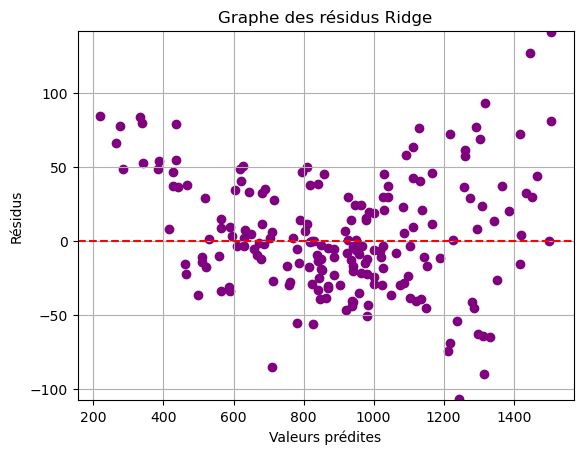

In [11]:
# Calcul des résidus
residusRidge = Y_test - PrevRidge

# Tracé du graphe des résidus
plt.scatter(PrevRidge, residusRidge, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Ridge")

plt.ylim(min(residusRidge) - 1, max(residusRidge) + 1) 
plt.grid(True)
plt.show()

#### ii. Avec sélection de variable (Cp/AIC/BIC et Lasso)

**LASSO**

Pour faire la pénalisation LASSO, On réalise d'abord une cross validation qui nous indique le lambda optimal. En python, la validation croisée est réalisée par GridSearchCV.

In [12]:
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":np.linspace(0.05, 5, 30) }]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, Y_train)
# paramètre optimal
alpha_opt = regLassOpt.best_params_["alpha"]
print("Meilleur paramètre = %s" % (regLassOpt.best_params_))

Meilleur paramètre = {'alpha': 1.2448275862068967}


Une fois le lambda réalisé on peut l'afficher sur les regularization paths (en R) pour voir les variables conservées par l'algorithme LASSO. En python, nous sommes obligé de reréaliser l'ajustement du modèle car GridSearchCV ne permet pas de garder les coefficients du modèles. Pour l'analyse nous avons donc besoin d'utiliser linear_model.Lasso directement.

Lasso conserve 11 variables et en supprime 9


Text(0.5, 1.0, 'Coefficients du modèle lasso')

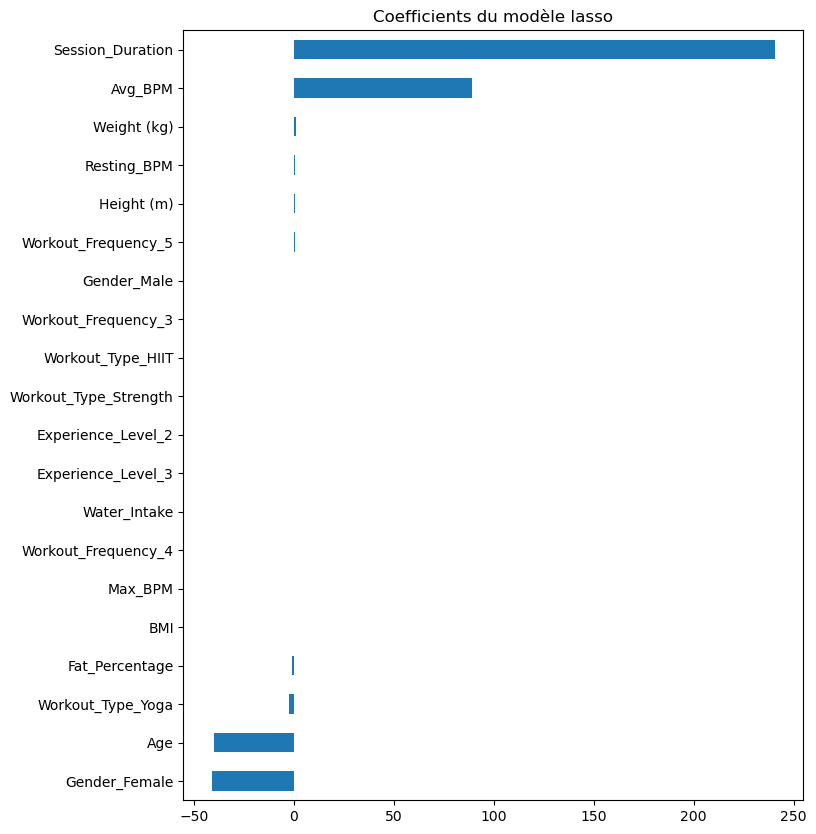

In [13]:
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])

# Entraîner sur tout le train, prédire sur le test
model_lasso=regLasso.fit(Xr_train,Y_train)
PrevLasso=regLasso.predict(Xr_test)
PrevLasso_train=regLassOpt.predict(Xr_train)

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

D'apres ce critère, les variables les plus interessantes pour prédire les carolies brûlées sont la durée de la session, le BPM moyen, le genre (Pour éviter les redondances, la modalitée princiaple gardée est le sexe féminin) et l'âge.

In [14]:
# Evaluation
r2_test= r2_score(Y_test, PrevLasso)
r2_train= r2_score(Y_train, PrevLasso_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = sum(coef != 0)  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevLasso)
mse_train = mean_squared_error(Y_train, PrevLasso_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9780
Q² (R²-ajusté sur test) = 0.9803
MSE sur test = 1585.5329
MSE sur train = 1550.8393


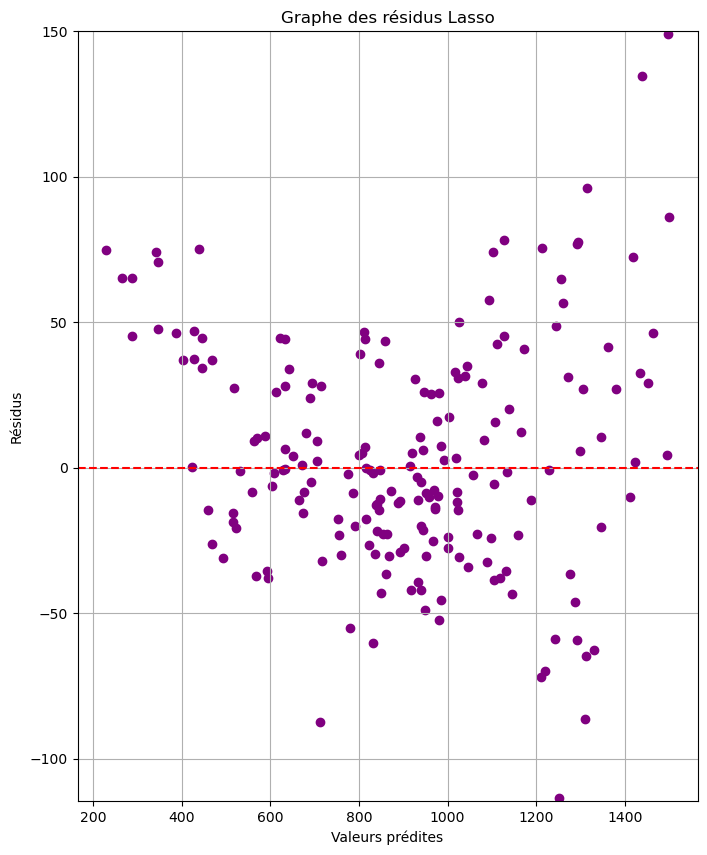

In [15]:
# Calcul des résidus
residusLasso = Y_test - PrevLasso

# Tracé du graphe des résidus
plt.scatter(PrevLasso, residusLasso, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Lasso")

plt.ylim(min(residusLasso) - 1, max(residusLasso) + 1) 
plt.grid(True)
plt.show()

Pour l'instant cette pénalisation semble pas avoir beaucoup d'effet. Bizarre que MSE diff de celle en R.

**Cp/AIC/BIC**

En python, il n'est pas possible d'utiliser ces méthodes de sélection de variable. En effet, sklearn ne propose pas directement de sélection par AIC. Nous nous refererons donc à notre notebook R pour cette méthode.

### c) Comparaison des modèles

Attention pour comparer les modèles il ne faut pas utiliser R2(echantillon train) mais Q2(sur échantillon test)!!

## 3) Support vector regression

In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.5],
    "kernel": ["rbf"],
    "gamma": ["scale", 0.01, 0.02, 0.1, 1]
}

#param=[{"C":[0.4,0.5,0.6,0.8,1,1.4, 1.8]}]
svm= GridSearchCV(SVR(),param_grid,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xr_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.022674, Meilleur paramètre = {'C': 100, 'epsilon': 0.5, 'gamma': 0.02, 'kernel': 'rbf'}


In [17]:
# erreur de prévision sur le test
1-svmOpt.score(Xr_test,Y_test)

0.014357142366811182

In [18]:
print("Score Q^2 :", svmOpt.score(Xr_test, Y_test))

Score Q^2 : 0.9856428576331888


## 4) Arbre Optimal

In [19]:
# Optimisation de la profondeur de l'arbre pour un problème de régression
param = [{"max_depth": list(range(2, 10))}]
tree = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(Xr_train, Y_train)

# Affichage du meilleur score (R² ici) et du meilleur paramètre
print("Meilleur score (R²) = %f, Meilleur paramètre = %s" % (treeOpt.best_score_, treeOpt.best_params_))

Meilleur score (R²) = 0.922390, Meilleur paramètre = {'max_depth': 9}


In [20]:
# Estimation de l'erreur de prévision
1-treeOpt.score(Xr_test,Y_test)

0.0637357623576923

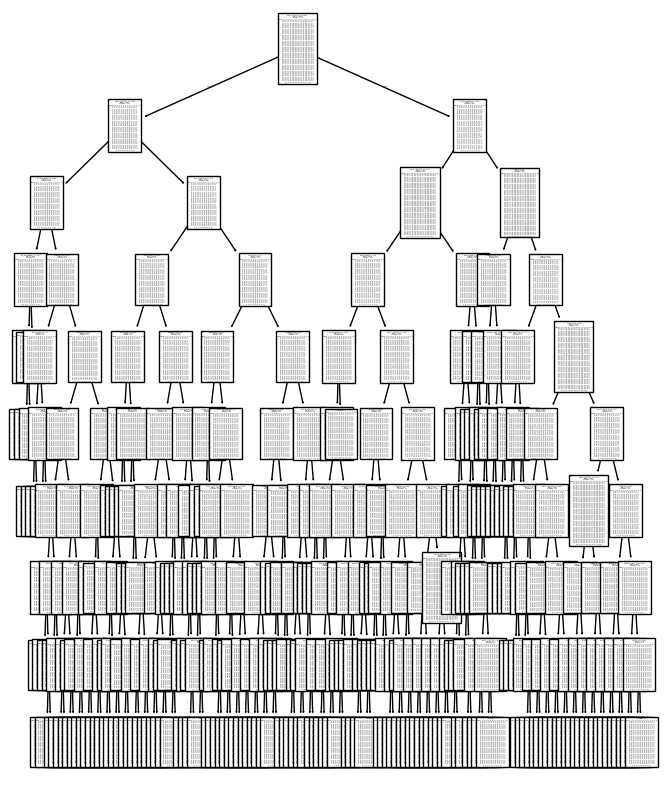

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

treeG=DecisionTreeClassifier(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(Xr_train,Y_train)
plot_tree(treeG,feature_names=dfC.columns.tolist());
plt.show()

## 5) Forêt aléatoire

In [22]:
from sklearn.ensemble import RandomForestClassifier 
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='sqrt', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(Xr_train,Y_train)
print(1-rfFit.oob_score_)

0.9961439588688946


In [23]:
# erreur de prévision sur le test
1-rfFit.score(Xr_test,Y_test)

0.9897435897435898

c'est bizarre qu'on ait un truc si proche de 1 parce que ça veut dire que l'erreur est énorme ...

In [24]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleur score = 0.991009, Meilleur paramètre = {'max_features': 2}


In [25]:
# erreur de prévision sur le test
1-rfOpt.score(Xr_test,Y_test)

0.9948717948717949

## 6) Boosting

## 7) Réseaux de neuronnes

# III- Prévision du niveau d'experience

In [26]:
GymDum=pd.get_dummies(Gym[["Gender","Workout_Type","Experience_Level","Workout_Frequency"]])
GymDum = GymDum.drop(columns=["Workout_Type_Cardio","Workout_Frequency_2"])
GymDum.head()

Y1=GymDum["Experience_Level_1"]
Y2=GymDum["Experience_Level_2"]
Y3=GymDum["Experience_Level_3"]

Y1.head()

0    False
1    False
2    False
3     True
4     True
Name: Experience_Level_1, dtype: bool

In [27]:
dfC2=pd.concat([GymDum,GymQuant],axis=1)
dfC2=dfC2.drop(columns=["Experience_Level_1","Experience_Level_2", "Experience_Level_3"]) 
dfC2.head()

,Gender_Female,Gender_Male,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Workout_Frequency_3,Workout_Frequency_4,Workout_Frequency_5,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Calories_Burned,Fat_Percentage,BMI,Session_Duration,Water_Intake
0,False,True,False,False,True,False,True,False,56,88.3,1.71,180,157,60,1313.0,12.6,5.495453,1.69,3.5
1,True,False,True,False,False,False,True,False,46,74.9,1.53,179,151,66,883.0,33.9,5.656854,1.30,2.1
2,True,False,False,False,False,False,True,False,32,68.1,1.66,167,122,54,677.0,33.4,4.970915,1.11,2.3
3,False,True,False,True,False,True,False,False,25,53.2,1.70,190,164,56,532.0,28.8,4.290688,0.59,2.1
4,False,True,False,True,False,True,False,False,38,46.1,1.79,188,158,68,556.0,29.2,3.793415,0.64,2.8


## 1) Séparation de la base en train/test

In [28]:
X1_train,X1_test,Y1_train,Y1_test=train_test_split(dfC2,Y1,test_size=0.2,random_state=11)
X2_train,X2_test,Y2_train,Y2_test=train_test_split(dfC2,Y2,test_size=0.2,random_state=11)
X3_train,X3_test,Y3_train,Y3_test=train_test_split(dfC2,Y3,test_size=0.2,random_state=11)

In [30]:
# L'algorithme des réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X1_train)  
scaler.fit(X2_train)  
scaler.fit(X3_train)  
Xb1_train = scaler.fit_transform(X1_train)  
Xb1_test = scaler.transform(X1_test)
Xb2_train = scaler.fit_transform(X2_train)  
Xb2_test = scaler.transform(X2_test)
Xb3_train = scaler.fit_transform(X3_train)  
Xb3_test = scaler.transform(X3_test)

## 2) Modèle linéaire

### i. Regression logistique

#### a) Niveau 1 d'Expérience Level

In [53]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt1=logit.fit(Xb1_train, Y1_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt1.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt1.best_score_,logitOpt1.best_params_))

Meilleur score = 0.124673, Meilleur paramètre = {'C': 1.2}


In [33]:
# erreur sur l'échantillon test
1-logitOpt1.score(Xb1_test, Y1_test)

0.1282051282051282

In [34]:
# Prévision
y_chap1 = logitOpt1.predict(Xb1_test)
# matrice de confusion
table=pd.crosstab(y_chap1,Y1_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_1  False  True 
row_0                           
False                 105     13
True                   12     65
Accuracy: 0.8717948717948718


L’objectif est de prédire si un utilisateur appartient au niveau d’expérience 1 à l’aide d’un modèle de classification binaire. On évalue la performance du modèle à l’aide d’une matrice de confusion, avec les résultats suivants :

Vrais positifs (TP) : 65 \
Faux positifs (FP) : 13\
Faux négatifs (FN) : 12\
Vrais négatifs (TN) : 105

Le taux de validité de cette matrice de confusion étant de 0,87, nous pouvons considérer que le modèle sait bien prédire les individus ayant un niveau d'expérience égal à 1. 


In [35]:
# Coefficients
logitLasso1=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef1=logitLasso1.fit(Xb1_train,Y1_train).coef_
print(logitCoef1[0])


[ 4.31237612e-02 -3.26597738e-02  0.00000000e+00  4.75021857e-02
 -1.78975234e-01 -2.66434733e+00 -5.10669200e+00 -2.47959852e+00
  2.13306069e-02  0.00000000e+00  6.22922955e-02 -7.10166257e-02
  2.28933807e-01 -1.10629317e-01 -9.75669403e-01  4.49886121e-02
 -3.43073601e-03 -7.39823245e-01  8.67450615e-02]


In [36]:
coef1 = pd.Series(logitCoef1[0], index = X1_train.columns)
print("Lasso conserve " + str(sum(coef1 != 0)) + 
      " variables et en supprime " +  str(sum(coef1 == 0)))

Lasso conserve 17 variables et en supprime 2


In [37]:
coef_df1 = pd.Series(logitCoef1[0], index=X1_train.columns)
print(coef_df1)
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df1[coef_df1 == 0])

Gender_Female            0.043124
Gender_Male             -0.032660
Workout_Type_HIIT        0.000000
Workout_Type_Strength    0.047502
Workout_Type_Yoga       -0.178975
Workout_Frequency_3     -2.664347
Workout_Frequency_4     -5.106692
Workout_Frequency_5     -2.479599
Age                      0.021331
Weight (kg)              0.000000
Height (m)               0.062292
Max_BPM                 -0.071017
Avg_BPM                  0.228934
Resting_BPM             -0.110629
Calories_Burned         -0.975669
Fat_Percentage           0.044989
BMI                     -0.003431
Session_Duration        -0.739823
Water_Intake             0.086745
dtype: float64
Variables avec coefficient nul (éliminées par Lasso) :
Workout_Type_HIIT    0.0
Weight (kg)          0.0
dtype: float64


Text(0.5, 1.0, 'Coefficients du modèle lasso')

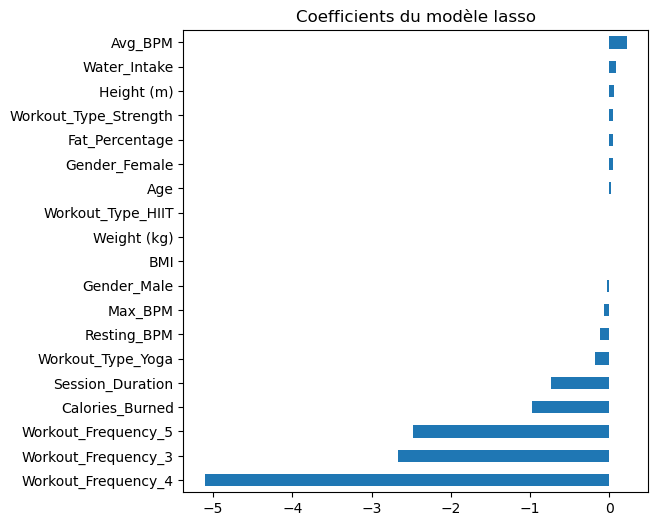

In [38]:
imp_coef = coef1.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

Les variables Workout_Type_HIIT, Weight (kg) et Gender_female ont un coefficient nul, ce qui signifie que le modèle ne les considère pas comme informatives pour la prédiction, compte tenu des autres variables disponibles. Ces variables sont donc éliminées automatiquement par la régularisation L1. Cela peut signifier qu’elles n’apportent pas d'information discriminante une fois les autres variables prises en compte, ou qu’elles sont corrélées à d'autres variables déjà présentes. 
    De plus, certaines variables ont un coéfficient important par rapport à d'autres, c'est le cas par exemple de Workout_Frequency_4 qui a un coefficient de -5.10. Cela siginifie que s’entraîner 4 fois par semaine est fortement négatif pour le niveau 1 d'Expérience_Level. Ainsi, Le modèle suggère la fréquence d’entraînement élevée ou modérée (3 à 5 fois par semaine) est négativement associée à la probabilité d’appartenir au niveau 1. Le niveau 1 représentant des débutants, cette analyse est logique en effet, un débutant ne va pas s'entraîner beaucoup au début ainsi une personne qui s'entraîne entre 3 et 5 fois par semaine a peu de chances d'être un débutant. 
     De même, la durée de la session ainsi que le nombre de calories brulées ont un coefficient négatif car elles sont généralement associées à des niveaux plus experimentés.  

#### b) Niveau 2 d'Expérience Level

In [54]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit2 = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt2=logit2.fit(Xb2_train, Y2_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt2.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt2.best_score_,logitOpt2.best_params_))

Meilleur score = 0.167047, Meilleur paramètre = {'C': 1}


In [43]:
# erreur sur l'échantillon test
1-logitOpt2.score(Xb2_test, Y2_test)

0.16410256410256407

In [44]:
# Prévision
y_chap2 = logitOpt2.predict(Xb2_test)
# matrice de confusion
table=pd.crosstab(y_chap2,Y2_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_2  False  True 
row_0                           
False                 104     17
True                   15     59
Accuracy: 0.8358974358974359


Dans ce nouveau cas, la matrice de cross-validation a un taux de validité de 83%, c'est légèrement inférieur au taux de validité de la matrice réalisée pour le niveau d'experience 1 ce qui peut sous-entendre que le niveau 2 est un peu moins bien prédit cependant le taux de validité est toujours très bon.

In [46]:
# Coefficients
logitLasso2=LogisticRegression(penalty="l1",C=logitOpt2.best_params_['C'],
                              solver="liblinear")
logitCoef2=logitLasso2.fit(Xb2_train,Y2_train).coef_
print(logitCoef2[0])


[-0.63490652  0.75362025  0.01198829 -0.10024335  0.06523555  2.52621419
  3.57831262  0.          0.          0.         -0.06637295  0.03248309
  0.          0.00908743  0.44928841  1.95886992  0.01447726  0.19131638
 -0.74437838]


In [47]:
coef2 = pd.Series(logitCoef2[0], index = X2_train.columns)
print("Lasso conserve " + str(sum(coef2 != 0)) + 
      " variables et en supprime " +  str(sum(coef2 == 0)))

Lasso conserve 15 variables et en supprime 4


In [48]:
coef_df2 = pd.Series(logitCoef2[0], index=X2_train.columns)
print(coef_df2)
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df2[coef_df2 == 0])

Gender_Female           -0.634907
Gender_Male              0.753620
Workout_Type_HIIT        0.011988
Workout_Type_Strength   -0.100243
Workout_Type_Yoga        0.065236
Workout_Frequency_3      2.526214
Workout_Frequency_4      3.578313
Workout_Frequency_5      0.000000
Age                      0.000000
Weight (kg)              0.000000
Height (m)              -0.066373
Max_BPM                  0.032483
Avg_BPM                  0.000000
Resting_BPM              0.009087
Calories_Burned          0.449288
Fat_Percentage           1.958870
BMI                      0.014477
Session_Duration         0.191316
Water_Intake            -0.744378
dtype: float64
Variables avec coefficient nul (éliminées par Lasso) :
Workout_Frequency_5    0.0
Age                    0.0
Weight (kg)            0.0
Avg_BPM                0.0
dtype: float64


Text(0.5, 1.0, 'Coefficients du modèle lasso')

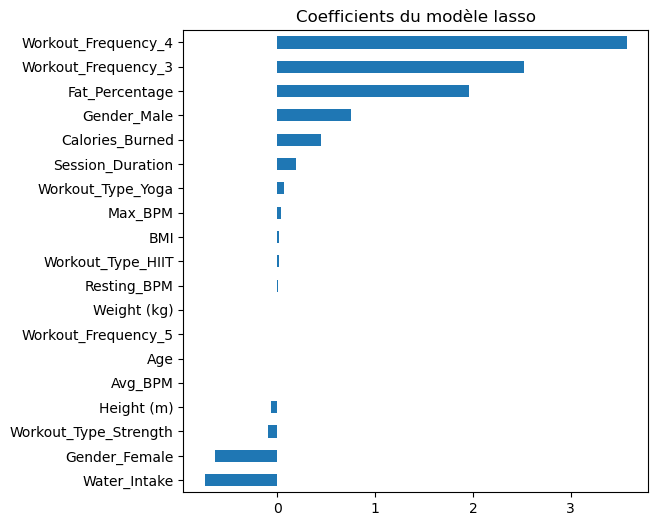

In [51]:
imp_coef2 = coef2.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef2.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

De la même manière que pour le niveau d'expérience1, la variable Weight (kg) a un coéfficient nul. C'est le cas aussi pour les variables Age, Wourkout_Frequency_5 et Avg_BPM. 
Parmi les facteurs les plus positivement corrélés à l’appartenance à ce groupe figurent la fréquence d’entraînement (notamment 3 fois par semaine : +2.53 et 4 fois : +3.58), ainsi que le taux de masse grasse (+1.96) et les calories brûlées (+0.45). Ces coefficients suggèrent que les pratiquants intermédiaires s’entraînent de manière relativement régulière et présentent une certaine dépense énergétique, tout en ayant un niveau de masse grasse significatif, ce qui peut indiquer un processus actif de recomposition corporelle.
Concernant les variables liées au genre, être homme est positivement associé (+0.75), tandis qu’être femme a un poids négatif (-0.63), ce qui peut refléter une répartition genrée dans cette tranche d'expérience (peut-être liée à des préférences ou à la distribution des pratiques sportives).
D’autres variables comme la durée des sessions (+0.19) ou le rythme cardiaque maximal (+0.03) contribuent légèrement positivement, indiquant des efforts d’intensité modérée à élevée. En revanche, la consommation d’eau est négativement corrélée (-0.74), ce qui peut surprendre et pourrait refléter un biais dans la saisie des données ou une corrélation indirecte (par exemple, une hydratation plus rigoureuse chez les débutants ou avancés).

#### c) Niveau 3 d'Expérience Level

In [55]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit3 = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt3=logit3.fit(Xb3_train, Y3_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt3.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt3.best_score_,logitOpt3.best_params_))

Meilleur score = 0.000000, Meilleur paramètre = {'C': 1}


In [56]:
# erreur sur l'échantillon test
1-logitOpt3.score(Xb3_test, Y3_test)

0.0

In [57]:
# Prévision
y_chap3 = logitOpt3.predict(Xb3_test)
# matrice de confusion
table=pd.crosstab(y_chap3,Y3_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_3  False  True 
row_0                           
False                 154      0
True                    0     41
Accuracy: 1.0


On peut voir ici que le modèle arrive à prédire parfaitement les individus ayant un niveau d'experience égal à 3. C'est surement du à des caractéristiques bien précises que ces individus possèdent et qui les distinguent des autres.

In [58]:
# Coefficients
logitLasso3=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef3=logitLasso3.fit(Xb3_train,Y3_train).coef_
print(logitCoef3[0])
coef3 = pd.Series(logitCoef3[0], index = X3_train.columns)
print("Lasso conserve " + str(sum(coef3 != 0)) + 
      " variables et en supprime " +  str(sum(coef3 == 0)))

[ 0.45896745 -1.13268645  0.          0.          0.         -0.20807072
  0.05304786  0.51019445  0.          0.          0.          0.
  0.          0.          0.         -4.65338976  0.          2.14581039
  0.04026963]
Lasso conserve 8 variables et en supprime 11


In [59]:
coef_df3 = pd.Series(logitCoef3[0], index=X3_train.columns)
print(coef_df3)
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df3[coef_df3 == 0])

Gender_Female            0.458967
Gender_Male             -1.132686
Workout_Type_HIIT        0.000000
Workout_Type_Strength    0.000000
Workout_Type_Yoga        0.000000
Workout_Frequency_3     -0.208071
Workout_Frequency_4      0.053048
Workout_Frequency_5      0.510194
Age                      0.000000
Weight (kg)              0.000000
Height (m)               0.000000
Max_BPM                  0.000000
Avg_BPM                  0.000000
Resting_BPM              0.000000
Calories_Burned          0.000000
Fat_Percentage          -4.653390
BMI                      0.000000
Session_Duration         2.145810
Water_Intake             0.040270
dtype: float64
Variables avec coefficient nul (éliminées par Lasso) :
Workout_Type_HIIT        0.0
Workout_Type_Strength    0.0
Workout_Type_Yoga        0.0
Age                      0.0
Weight (kg)              0.0
Height (m)               0.0
Max_BPM                  0.0
Avg_BPM                  0.0
Resting_BPM              0.0
Calories_Burned        

Text(0.5, 1.0, 'Coefficients du modèle lasso')

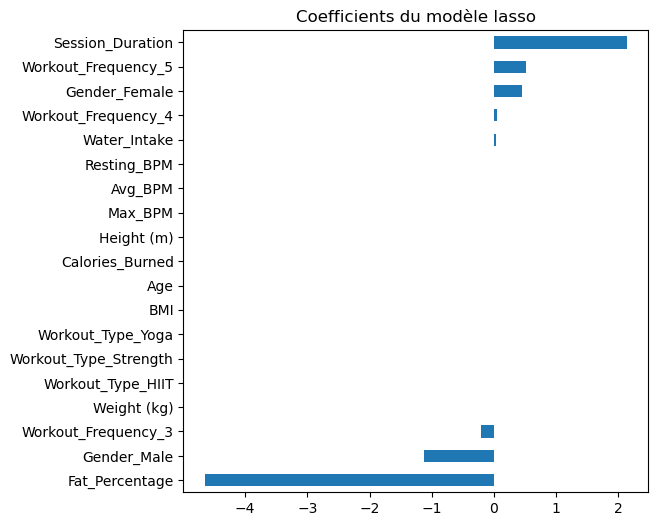

In [60]:
imp_coef3 = coef3.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef3.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

De nombreuses variables ont été écartées par la régularisation Lasso, notamment : les types d’entraînement (HIIT, Strength, Yoga), les mesures physiologiques (fréquence cardiaque, IMC, poids, taille, âge, etc.), ainsi que les calories brûlées. Leur absence dans le modèle suggère qu’elles n’ajoutent pas de pouvoir discriminant supplémentaire pour identifier les individus de niveau avancé, probablement parce que les avancés présentent une grande homogénéité sur ces aspects ou que d’autres variables (durée de la session, masse grasse) capturent déjà ces effets. La variable ayant le plus fort impact négatif est le taux de masse grasse (-4.65), ce qui suggère que les individus de ce niveau présentent un taux de masse grasse nettement inférieur, caractéristique fréquente chez des sportifs plus aguerris ayant optimisé leur composition corporelle. À l'inverse, la durée des sessions a un effet fortement positif (+2.15), ce qui indique que les pratiquants avancés ont tendance à s’entraîner plus longtemps, confirmant un engagement plus intense et structuré. Sur le plan du genre, être femme est positivement associé à ce niveau (+0.46), tandis qu’être homme est fortement négatif (-1.13), ce qui pourrait indiquer une prédominance féminine parmi les sportifs avancés dans cet échantillon, ou des différences de comportements d'entraînement genrés. Concernant la fréquence d’entraînement, le fait de s'entraîner 5 fois par semaine est modérément positif (+0.51), alors que 3 fois par semaine est légèrement négatif (-0.21), soulignant que les pratiquants avancés s'entraînent davantage que les niveaux précédents. La fréquence de 4 fois par semaine a un effet très faible (+0.05), ce qui suggère une limite intermédiaire sans distinction marquée.

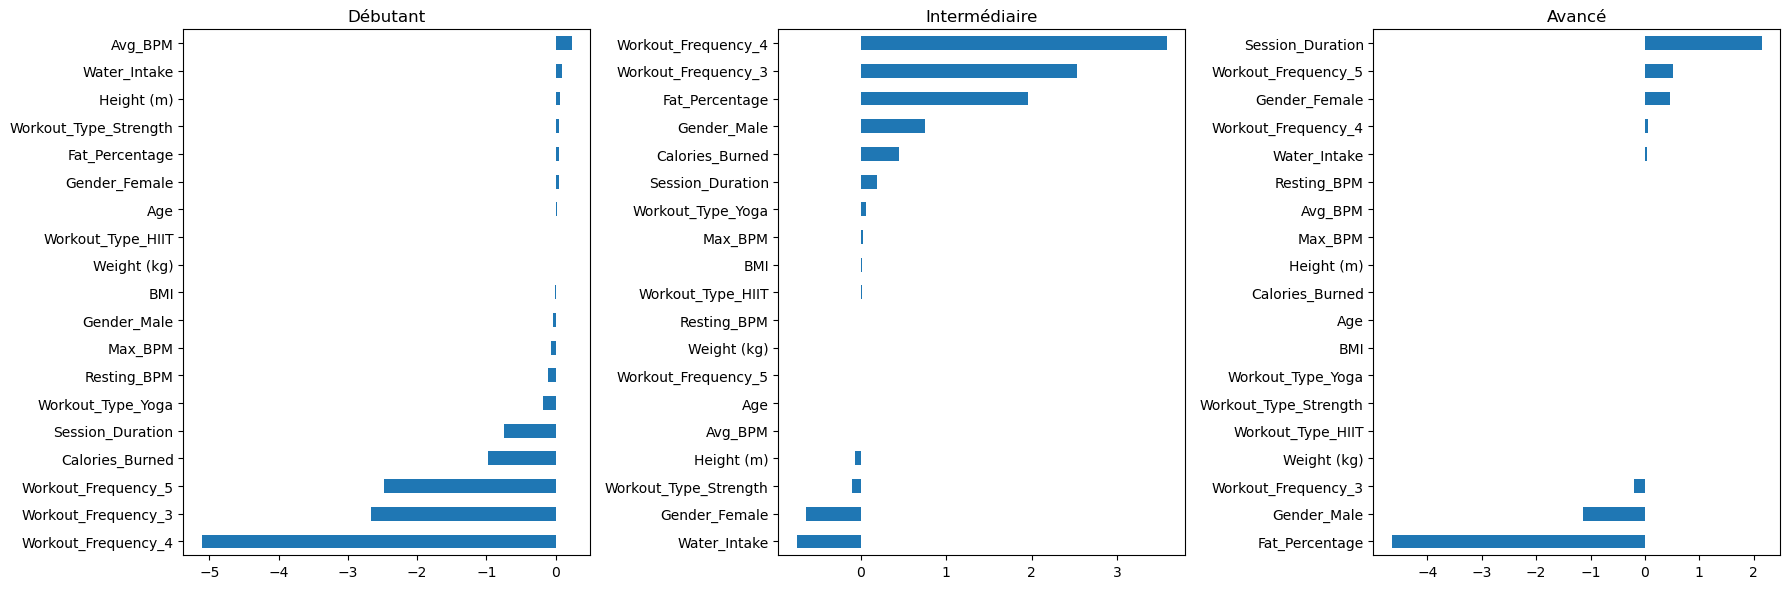

In [61]:
imp_coef1 = coef1.sort_values()
imp_coef2 = coef2.sort_values()
imp_coef3 = coef3.sort_values()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  


imp_coef1.plot(kind="barh", ax=axes[0])
axes[0].set_title("Débutant")

imp_coef2.plot(kind="barh", ax=axes[1])
axes[1].set_title("Intermédiaire")

imp_coef3.plot(kind="barh", ax=axes[2])
axes[2].set_title("Avancé")

plt.tight_layout()
plt.show()

L’analyse des modèles de régression logistique pour chaque niveau d’expérience (Débutant, Intermédiaire, Avancé) révèle des évolutions nettes dans les profils des pratiquants au fil de leur progression.\
Débutants : Ce groupe est fortement associé à une fréquence d’entraînement faible, notamment 3 ou 4 fois par semaine, avec des coefficients fortement négatifs. Ils présentent également une moindre dépense calorique et des sessions plus courtes, ce qui suggère une implication encore modérée dans leur routine sportive. Les variables physiologiques (âge, poids, fréquence cardiaque) sont peu discriminantes, et leur influence est souvent éliminée du modèle.\
Intermédiaires : On observe une transition claire. Ces individus s’entraînent plus fréquemment (3 à 4 fois/semaine) et présentent des signes d’un engagement croissant : calories brûlées, masse grasse et durée des sessions sont des facteurs positivement corrélés. Le genre masculin est également plus représenté. Ce niveau se distingue par une phase de structuration de l'entraînement, avec une intensification visible des efforts.\
Avancés : Les pratiquants avancés ont un profil très distinct. Le taux de masse grasse est fortement négatif, ce qui témoigne d’un niveau élevé de condition physique. La durée des séances est le facteur le plus discriminant, indiquant un investissement significatif en temps. La variable genre est inversée : ici, le genre féminin est associé positivement, ce qui peut refléter des habitudes spécifiques ou une plus grande constance chez certaines pratiquantes. La fréquence d'entraînement à 5 fois/semaine devient une vraie caractéristique de ce niveau.

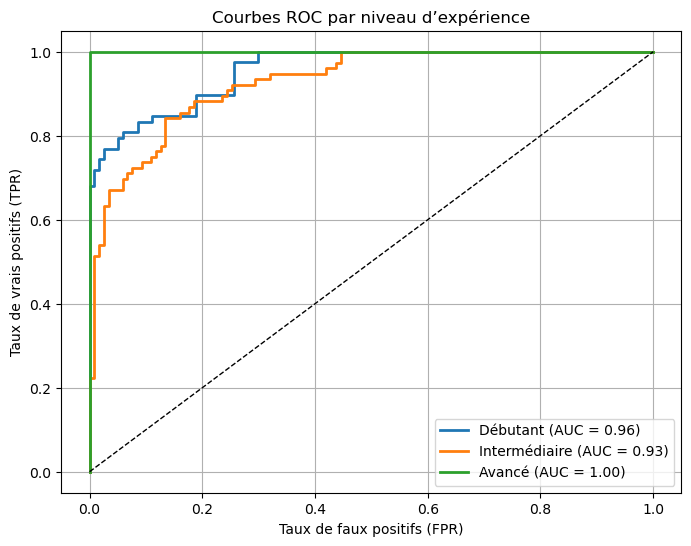

In [67]:
from sklearn.metrics import auc
probas1 = LogisticRegression(penalty="l1", solver="liblinear", 
                             C=logitOpt1.best_params_['C']).fit(X1_train, Y1_train).predict_proba(X1_test)
fpr1, tpr1, _ = roc_curve(Y1_test, probas1[:, 1])
auc1 = auc(fpr1, tpr1)

# Modèle pour niveau Intermédiaire
probas2 = LogisticRegression(penalty="l1", solver="liblinear", 
                             C=logitOpt2.best_params_['C']).fit(X2_train, Y2_train).predict_proba(X2_test)
fpr2, tpr2, _ = roc_curve(Y2_test, probas2[:, 1])
auc2 = auc(fpr2, tpr2)

# Modèle pour niveau Avancé
probas3 = LogisticRegression(penalty="l1", solver="liblinear", 
                             C=logitOpt3.best_params_['C']).fit(X3_train, Y3_train).predict_proba(X3_test)
fpr3, tpr3, _ = roc_curve(Y3_test, probas3[:, 1])
auc3 = auc(fpr3, tpr3)

# Tracer les courbes ROC
plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, label=f"Débutant (AUC = {auc1:.2f})", lw=2)
plt.plot(fpr2, tpr2, label=f"Intermédiaire (AUC = {auc2:.2f})", lw=2)
plt.plot(fpr3, tpr3, label=f"Avancé (AUC = {auc3:.2f})", lw=2)
plt.plot([0,1], [0,1], 'k--', lw=1)

plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC par niveau d’expérience')
plt.legend(loc="lower right")
plt.grid()
plt.show()

L’évaluation des modèles de régression logistique à travers les courbes ROC met en évidence une performance globale très satisfaisante pour chacun des niveaux d’expérience. Le modèle destiné aux débutants atteint une aire sous la courbe (AUC) de 0.96, indiquant une excellente capacité de discrimination. Celui des intermédiaires présente également une bonne performance (AUC = 0.93), bien que légèrement inférieure, suggérant une plus grande variabilité dans ce groupe. Enfin, le modèle associé aux utilisateurs avancés affiche une performance parfaite (AUC = 1.00), ce qui peut révéler une excellente pertinence des variables explicatives. On peut cependant se méfier d'un surapprentissage dans le dernier cas.

### ii. LSVM

## 3)SVR/SVM

In [68]:

param=[{"C":[0.4,0.5,0.6,0.8,1,1.4]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt1=svm.fit(Xb1_train, Y1_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt1.best_score_,svmOpt1.best_params_))

Meilleur score = 0.129770, Meilleur paramètre = {'C': 0.6}


In [69]:
# erreur de prévision sur le test
1-svmOpt1.score(Xb1_test,Y1_test)

0.15384615384615385

In [70]:
# prévision de l'échantillon test
y_chap1 = svmOpt1.predict(Xb1_test)
# matrice de confusion
table=pd.crosstab(y_chap1,Y1_test)
print(table)

Experience_Level_1  False  True 
row_0                           
False                 106     19
True                   11     59


## 4) Arbre optimal CART

## 5) Forêt aléatoire

## 6) Boosting

## 7) Réseaux de neuronne